<a href="https://colab.research.google.com/github/TanushGoel/Gordon-RamsAI/blob/master/Gordon_RamsAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -q -o "recipes_data.zip"

In [1]:
import pandas as pd

recipes = pd.read_csv("recipes_data/RAW_recipes.csv")
recipes["steps"] = [eval(recipe_steps) for recipe_steps in recipes["steps"]] # convert list-formatted string into a list
recipes["steps"] = [" ".join(steps) for steps in recipes["steps"]] # turn the steps into a single string
print(len(recipes))
recipes.head()

231637


,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,make a choice and proceed with recipe dependin...,autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,preheat oven to 425 degrees f press dough into...,this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,brown ground beef in large pot add chopped oni...,this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,place potatoes in a large pot of lightly salte...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"mix all ingredients& boil for 2 1 / 2 hours , ...",my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [2]:
interactions = pd.read_csv("recipes_data/RAW_interactions.csv")
print(len(interactions))
interactions.head()

1132367


,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


In [3]:
averaged_ratings = [] # create averaged ratings for each recipe from the interactions data
for id in recipes.id:
    all_ratings = interactions.loc[interactions['recipe_id'] == id].rating
    averaged_ratings.append(sum(all_ratings) / len(all_ratings))

In [4]:
import string 

data = pd.DataFrame({"name": [str(name).lower() for name in recipes["name"]],
                     "steps": [''.join(c for c in s.lower() if c not in string.punctuation) for s in recipes["steps"]],  
                     "rating": averaged_ratings})
data = data[data['rating'] >= 3.25].drop('rating', axis=1) # only keep the recipes with an average rating of 3.25 or higher
data = data.sample(frac=1).reset_index(drop=True) # shuffle dataframe
del recipes, interactions, averaged_ratings
print(len(data))
data.head()

207866


,name,steps
0,breakfast ham casserole,beat eggs add cooled sausage or ham add other...
1,oyster dressing to die for,preheat oven to 350f to make cornbread combin...
2,dutch leek casserole,preheat oven to 350 degrees f bring a large po...
3,salmon with fennel,thinly slice both the onion and the fennel bul...
4,banana filled chocolate enchiladas,for the crepes whisk together all of the dry i...


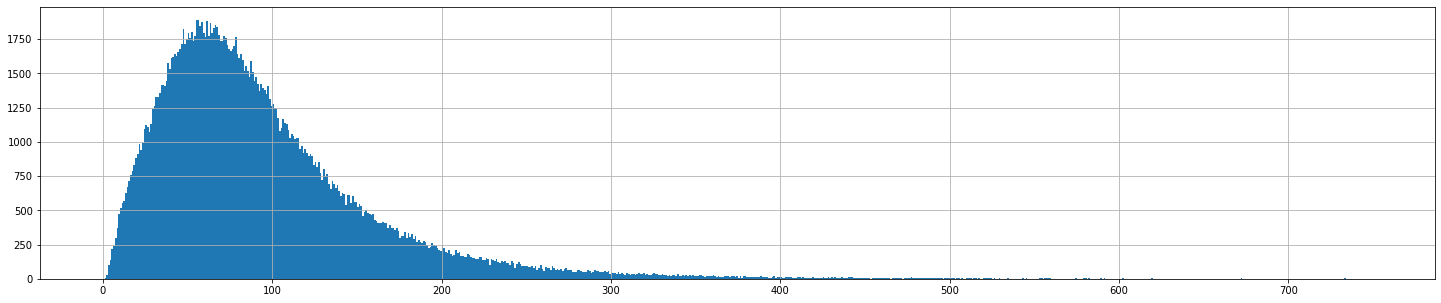

In [5]:
# visualize amount of words in recipe steps
import numpy as np
pd.DataFrame([len(text.split()) for text in data.steps])[0].hist(bins=np.arange(start=0, stop=750, step=1), figsize=[25,5])

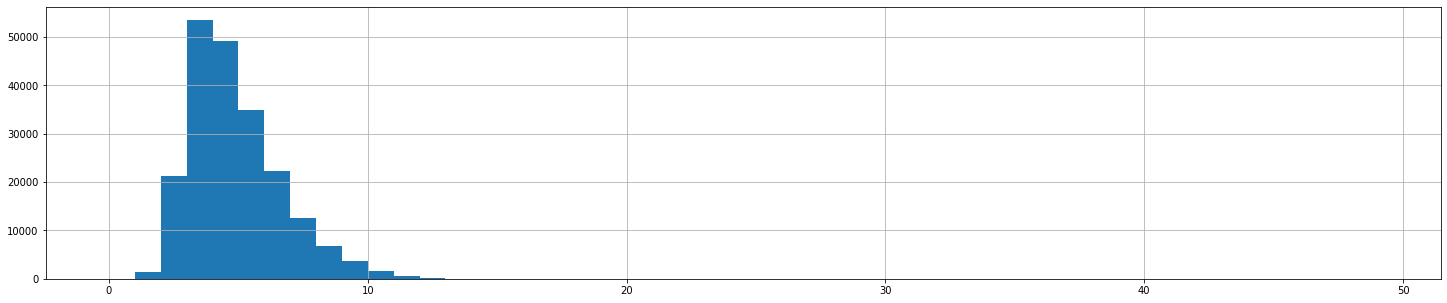

In [6]:
# visualize amount of words in recipe names
pd.DataFrame([len(text.split()) for text in data.name])[0].hist(bins=np.arange(start=0, stop=50, step=1), figsize=[25,5])

In [7]:
max_steps_len = 256
max_name_len = 16

data = data[data['steps'].str.split().str.len().le(max_steps_len-2)] # subtract two for SOS and EOS tokens
data = data[data['name'].str.split().str.len().le(max_name_len-2)] # subtract two for SOS and EOS tokens
len(data)

201619

In [8]:
import nltk
!python -m nltk.downloader all  -q

from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
porter = PorterStemmer()

def process_text(text):

    tokens = word_tokenize(text) # break into words
    stemmed = [porter.stem(word) for word in tokens] # stemming = process of reducing a word to its root or base --> “fishing,” “fished,” “fisher” all reduce to the stem “fish”
    stemmed.insert(0, "<start>")
    stemmed.append("<end>")

    return stemmed

data.steps = data.steps.apply(process_text)
data.name = data.name.apply(process_text)
data.head()

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


,name,steps
0,"[<start>, breakfast, ham, casserol, <end>]","[<start>, beat, egg, add, cool, sausag, or, ha..."
1,"[<start>, oyster, dress, to, die, for, <end>]","[<start>, preheat, oven, to, 350f, to, make, c..."
2,"[<start>, dutch, leek, casserol, <end>]","[<start>, preheat, oven, to, 350, degre, f, br..."
3,"[<start>, salmon, with, fennel, <end>]","[<start>, thinli, slice, both, the, onion, and..."
4,"[<start>, banana, fill, chocol, enchilada, <end>]","[<start>, for, the, crepe, whisk, togeth, all,..."


In [9]:
print(data.steps[0])

['<start>', 'beat', 'egg', 'add', 'cool', 'sausag', 'or', 'ham', 'add', 'other', 'ingredi', 'pour', 'into', '9x13in', 'pyrex', 'dish', 'cover', 'with', 'saran', 'wrap', 'and', 'refriger', 'overnight', 'let', 'sit', 'out', 'one', 'hour', 'befor', 'bake', 'bake', 'at', '350f', 'until', 'puf', 'and', 'lightli', 'brown', '<end>']


In [10]:
print(data.steps.map(lambda x: len(x)).max()) # 256
print(data.name.map(lambda x: len(x)).max()) # 16

256
16


In [11]:
vocab = []
for text in data.name + data.steps:
    vocab += text
vocab = list(set(vocab))
word_to_int = dict(zip(vocab, range(1, len(vocab)+1)))
int_to_word = {v: k for k, v in word_to_int.items()}
print(len(vocab), "words in vocab")
num_words = len(vocab)+1 # add one for padding 0's
print(vocab[:100])

51503 words in vocab
['checkpea', 'netmeg', 'microfib', 'beehoon', 'secsond', 'neeli', 'wonder', 'mediom', 'butterco', 'eintir', 'faintli', 'salttogeth', 'cheesesideup', 'fillingth', 'spitfir', 'leekgarl', 'nonwimpi', '1tbl', 'freezecool', 'everglad', 'mashti', 'siet', 'woolton', 'salsachees', 'cherrri', 'vach', 'crunch', 'rabe', 'pring', 'spagaga', 'gao', 'yelloworangeish', 'boulet', 'worchestrshir', 'egremont', 'whipp', 'nowherb', '5031', 'bulg', 'vegetab', 'floral', 'dariol', 'talerina', 'necklac', '2x2in', 'oast', 'watersoak', 'wame', 'fruitcaka', 'maynaiss', 'minxtur', 'panel', 'tofirm', 'potatoif', 'by2inch', 'sizeabl', 'beanjuic', 'maxin', 'parowax', 'eggss', 'piperati', 'easilyso', 'nonliquid', 'restart', 'swissrol', '324', 'talespoon', 'brussl', 'mim', 'journalist', 'deb', 'extravaganza', 'yeat', 'deseed', 'grownup', 'rem', 'too15', '19cmx19cm', 'feijo', 'carniv', '6090minut', 'derek', 'dought', '156', 'pareil', 'decatur', 'servewith', 'mchewek', 'sapphir', 'fetayogurt', 'pfef

In [ ]:
# lstm model

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import initializers

encoder_in = layers.Input(shape=(max_name_len,), dtype='int32', name='encoder_in')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_encoder = layers.Embedding(output_dim=32, input_dim=num_words, input_length=max_name_len)(encoder_in) 

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
lstm_encoder = tf.compat.v1.keras.layers.CuDNNLSTM(128, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(embed_encoder)
activation1_encoder = layers.PReLU()(lstm_encoder)
dropout1_encoder = layers.Dropout(0.1)(activation1_encoder)

decoder_in = layers.Input(shape=(max_steps_len,), dtype='int32', name='decoder_in')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_decoder = layers.Embedding(output_dim=128, input_dim=num_words, input_length=max_name_len)(decoder_in) 

# concat encoder output with steps embeddings
concat = layers.concatenate([dropout1_encoder, embed_decoder], axis=1)

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
lstm_decoder = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(concat)
activation1_decoder = layers.PReLU()(lstm_decoder)
dropout1_decoder = layers.Dropout(0.1)(activation1_decoder)
lstm_decoder = tf.compat.v1.keras.layers.CuDNNLSTM(512, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(dropout1_decoder)
activation2_decoder = layers.PReLU()(dropout1_decoder)
dropout2_decoder = layers.Dropout(0.1)(activation2_decoder)
lstm_decoder = tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros())(dropout2_decoder)
activation3_decoder = layers.PReLU()(lstm_decoder)
dropout3_decoder = layers.Dropout(0.1)(activation3_decoder)

# turn into vector
decoded_vec = layers.GlobalAveragePooling1D()(dropout3_decoder)

# dense layers 
dense1 = layers.Dense(512, activation='relu')(decoded_vec)
dropout1_dense = layers.Dropout(0.1)(dense1)
dense2 = layers.Dense(256, activation='relu')(dropout1_dense)

# output
output = layers.Dense(num_words, activation="softmax", name='output')(dense2) 

model = Model(inputs=[encoder_in, decoder_in], outputs=[output])

model.summary()

In [47]:
# bidirectional lstm model

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import initializers

encoder_in = layers.Input(shape=(max_name_len,), dtype='int32', name='encoder_in')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_encoder = layers.Embedding(output_dim=32, input_dim=num_words, input_length=max_name_len)(encoder_in) 

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
lstm_encoder = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(64, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros()))(embed_encoder)
activation1_encoder = layers.PReLU()(lstm_encoder)
dropout1_encoder = layers.Dropout(0.1)(activation1_encoder)

decoder_in = layers.Input(shape=(max_steps_len,), dtype='int32', name='decoder_in')

# encode the input sequence into a sequence of dense n-dimensional vectors
embed_decoder = layers.Embedding(output_dim=128, input_dim=num_words, input_length=max_name_len)(decoder_in) 

# concat encoder output with steps embeddings
concat = layers.concatenate([dropout1_encoder, embed_decoder], axis=1)

# use LSTM to transform the vector sequence into a single vector containing information about the entire sequence
lstm_decoder = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros()))(concat)
activation1_decoder = layers.PReLU()(lstm_decoder)
dropout1_decoder = layers.Dropout(0.1)(activation1_decoder)
lstm_decoder = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(512, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros()))(dropout1_decoder)
activation2_decoder = layers.PReLU()(dropout1_decoder)
dropout2_decoder = layers.Dropout(0.1)(activation2_decoder)
lstm_decoder = layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(256, return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.2), bias_initializer=initializers.Zeros()))(dropout2_decoder)
activation3_decoder = layers.PReLU()(lstm_decoder)
dropout3_decoder = layers.Dropout(0.1)(activation3_decoder)

# turn into vector
decoded_vec = layers.GlobalAveragePooling1D()(dropout3_decoder)

# dense layers 
dense1 = layers.Dense(512, activation='relu')(decoded_vec)
dropout1_dense = layers.Dropout(0.1)(dense1)
dense2 = layers.Dense(256, activation='relu')(dropout1_dense)

# output
output = layers.Dense(num_words, activation="softmax", name='output')(dense2) 

model = Model(inputs=[encoder_in, decoder_in], outputs=[output])

model.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_in (InputLayer)         [(None, 16)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 16, 32)       1648128     encoder_in[0][0]                 
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 16, 128)      50176       embedding_10[0][0]               
__________________________________________________________________________________________________
p_re_lu_17 (PReLU)              (None, 16, 128)      2048        bidirectional_1[0][0]            
_______________________________________________________________________________________

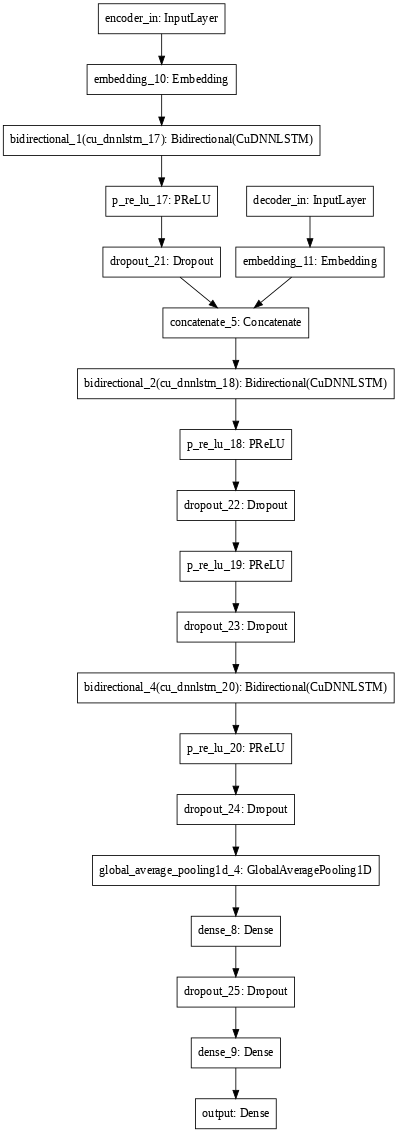

In [48]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60)

In [49]:
model.compile(optimizer = 'adam', 
              loss = {'output': 'categorical_crossentropy'},
              metrics = {'output': "accuracy"}) 

In [50]:
def make_sequence_steps(text):

    seqs = []
    for words in text:
        seq = [word_to_int[word] for word in words]
        while len(seq) != max_steps_len:
            seq.append(0)
        seqs.append(seq)
    return seqs

def make_sequence_name(text):

    seqs = []
    for words in text:
        seq = [word_to_int[word] for word in words]
        while len(seq) != max_name_len:
            seq.append(0)
        seqs.append(seq)
    return seqs

In [51]:
batch_siz = 5000

def make_data(df, start1, start2):

    last = False
    steps_broken = []
    next_words = []
    names = []
    for idx in range(start1, len(df)): # start from where left off until end of data
        steps = df.steps.iloc[idx] # ["<start>", "preheat", "oven", ... , "<end>"]
        for cutoff in range(start2, len(steps)-1): # start from where left off until end of recipe steps word list
            if len(steps_broken) < batch_siz:
                steps_broken.append(steps[:cutoff+1]) # [["<start>"], ["<start>", "preheat"], ["<start>", "preheat", "oven"], ..., ["<start>", "preheat", "oven", ...]] # does not include EOS
                next_words.append(steps[cutoff+1]) # ["preheat", "oven", ... , "<end>"] # does not include SOS
                names.append(df.name.iloc[idx]) # [[<start>, dutch, leek, casserol, <end>], [<start>, dutch, leek, casserol, <end>], [<start>, dutch, leek, casserol, <end>], ...]
            else:
                return steps_broken, next_words, names, idx, cutoff, last
        start2 = 0

    last = True
    return steps_broken, next_words, names, idx, cutoff, last

In [ ]:
epochz = 1

for epoch in range(epochz): # batch_siz = 5000 --> 3570 batches ~ 6 seconds per batch (batch_size=512) ~ 6 hours per epoch

    print("\nStarting Epoch:", epoch+1)

    start1 = 0
    start2 = 0
    while True:

        steps, next_words, names, start1, start2, last = make_data(data, start1, start2)

        names_seqs = np.array(make_sequence_name(names), dtype="int32")
        steps_seqs = np.array(make_sequence_steps(steps), dtype="int32")
        next_words = tf.keras.utils.to_categorical([word_to_int[word] for word in next_words], num_classes=num_words, dtype='int32')

        model.fit({'encoder_in': names_seqs, 
                   'decoder_in': steps_seqs},
                  {'output': next_words},
                  shuffle=True, 
                  epochs=1, 
                  batch_size=512)

        if last:
            break

In [53]:
def make_recipe(name):

    name_in = process_text(name)

    if len(name_in) > 16:
        print("name has to be 14 words or less")
        return

    try:
        name_in = [word_to_int[word] for word in name_in]
    except:
        print("oops, one of the words entered is not in my vocabulary")
        return

    while len(name_in) != max_name_len:
        name_in.append(0)
    name_in = np.array(name_in, dtype="int32")

    steps_in = np.zeros(max_steps_len, dtype="int32")
    steps_in[0] = word_to_int["<start>"]

    preds = []
    for idx in range(1, max_steps_len):

        pred_int = np.argmax(model.predict({'encoder_in': name_in.reshape(1, max_name_len,), 
                                            'decoder_in': steps_in.reshape(1, max_steps_len,)}))
        next_pred_word = int_to_word[pred_int]

        if next_pred_word == "<end>":
            return preds
        else:
            preds.append(next_pred_word)

        steps_in[idx] = pred_int
        
    return preds

In [ ]:
make_recipe("large chocolate chip cookies")